# History Matching for L96
Author : Redaoune Lguensat, Homer Durand

Date : 04-08-2021

### Loading libs

In [1]:
PATH = '/home/homer/anaconda3/envs/HM/bin/python'
Sys.setenv(RETICULATE_PYTHON = PATH)

current_dir <- getwd()
mogp_dir <- current_dir #mogp_emulator lib : https://github.com/alan-turing-institute/mogp-emulator

setwd(paste0(current_dir, '/dev_ExeterUQ_MOGP/')) #devel version og ExeterUQ_MOGP : https://github.com/BayesExeter/ExeterUQ_MOGP/tree/devel

source("BuildEmulator/BuildEmulator.R")
source("HistoryMatching/HistoryMatching.R")
source("HistoryMatching/impLayoutplot.R")

setwd(current_dir)

r_packages <- c('reticulate', 'future.apply', 'tgp', 'ANN2', 'MLmetrics', 'keras')
invisible(lapply(r_packages, library, character.only = TRUE))

use_condaenv("HM")

python_pkg <- c("L96_amip", "numpy", "sklearn", "skopt.sampler", "skopt.space")
python_pkg_names <- c("L96_amip", "np", "sklearn", "sampler", "skSpace")
for(i in seq(length(python_pkg))){assign(python_pkg_names[i], import(python_pkg[i]))}

far library : Modelization for Functional AutoRegressive processes


version 0.6-4 (2014-12-07)


Spam version 2.6-0 (2020-12-14) is loaded.
Type 'help( Spam)' or 'demo( spam)' for a short introduction 
and overview of this package.
Help for individual functions is also obtained by adding the
suffix '.spam' to the function name, e.g. 'help( chol.spam)'.


Attaching package: ‘spam’


The following objects are masked from ‘package:base’:

    backsolve, forwardsolve


See https://github.com/NCAR/Fields for
 an extensive vignette, other supplements and source code 

This is loo version 2.4.1

- Online documentation and vignettes at mc-stan.org/loo

- As of v2.0.0 loo defaults to 1 core but we recommend using as many as possible. Use the 'cores' argument or set options(mc.cores = NUM_CORES) for an entire session. 

Loading required package: future


Attaching package: ‘MLmetrics’


The following object is masked from ‘package:base’:

    Recall



Attaching package: ‘keras’


The following

# History Matching

1. Space filling design of parameters space
2. Data simulation
3. Training of statistical emulator
4. Computation of implausibility
5. Refocussing
    * If stoping criterion is reached stop HM
    * Else, redefining parameters space and go to 1.

## Observations generation

As our model is a toy model we need to generate *observations* based on the ground truth parameters in order to use them to tune our model. In a realistic model (e.g. an ocean model), observations are metrics based on real observations of the state of the ocean threw time.

$\frac{d X_{k}}{d t}=\underbrace{-X_{k-1}\left(X_{k-2}-X_{k+1}\right)}_{\text {Advection}} \underbrace{-X_{k}}_{\text {Diffusion}}+\underbrace{F}_{\text {Forcing}} \underbrace{-h c \bar{Y}_{k}}_{\text {Coupling}}$

$\frac{1}{c} \frac{d Y_{j, k}}{d t}=\underbrace{-b Y_{j+1, k}\left(Y_{j+2, k}-Y_{j-1, k}\right)}_{\text {Advection }} \underbrace{-Y_{j, k}}_{\text {Diffusion }} \underbrace{+\frac{h}{J} X_{k}}_{\text {Coupling }}$

We consider the correct parameters to be h=1, F=10, c=10, b=10 and we will first generate our metrics based on those inputs using the 65 terms depicted here as in Schneider et al. 2017. 

$$
\boldsymbol{f}_k(Y)=\left(\begin{array}{c}
Y_{j,k} \\
Y_{j,k}Y_{j',k}
\end{array}\right), \forall j, j' \in J \text{ and } k \in K
$$

In [2]:
np$random$seed(as.integer(42))

X_init = 10*np$ones(as.integer(36))
X_init[19]=1.0001 #ATtention X_init[19] !!!

l96_two = L96_amip$L96TwoLevel(save_dt=0.001, X_init=X_init, integration_type='coupled') # True params J=10, h=1, F=10, c=10, b=10

We first iterate 10 iterations in order to access to the steady state of the L96 model

In [3]:
l96_two$iterate(10)

In [4]:
X_init = l96_two$X

We can use *Newinit* to be sure to start from the attractor of the L96.

In [5]:
np$random$seed(as.integer(42))

n_iter <- 40

X_init = 10*np$ones(as.integer(36))
X_init[19]=1.0001 #ATtention X_init[19] !!!

l96_two = L96_amip$L96TwoLevel(save_dt=0.001, X_init=X_init, integration_type='coupled') # True params J=10, h=1, F=10, c=10, b=10

In [6]:
l96_two$iterate(n_iter)

We save the history of X in order to reinject it during the Y integration.

In [7]:
X_hist <- l96_two$history$X$values

We save the metrics generate with the ground truth parameters (observations).

In [8]:
system.time(observations <- l96_two$mean_stats(ax=as.integer(0), amip_metrics=FALSE))

   user  system elapsed 
  0.584   0.064   0.650 

We now have our ground truth metrics and history of X wo we can tune our model.

### Generation of metrics for the first wave

We first sample the parameters space (input space) using a space filling design (latin hypercube sampling with maximin criterion) and then will generate our metrics for each of those points of the parameter space.

In [9]:
n_samples <- 40

In [10]:
space <- skSpace$Space(list(c(-2, 2), c(-20,20), c(0, 20), c(-20, 20))) ##only h,F,c,b
lhs <- sampler$Lhs()
inputs_wave1 <- np$array(lhs$generate(space$dimensions, as.integer(n_samples), random_state=as.integer(42)))

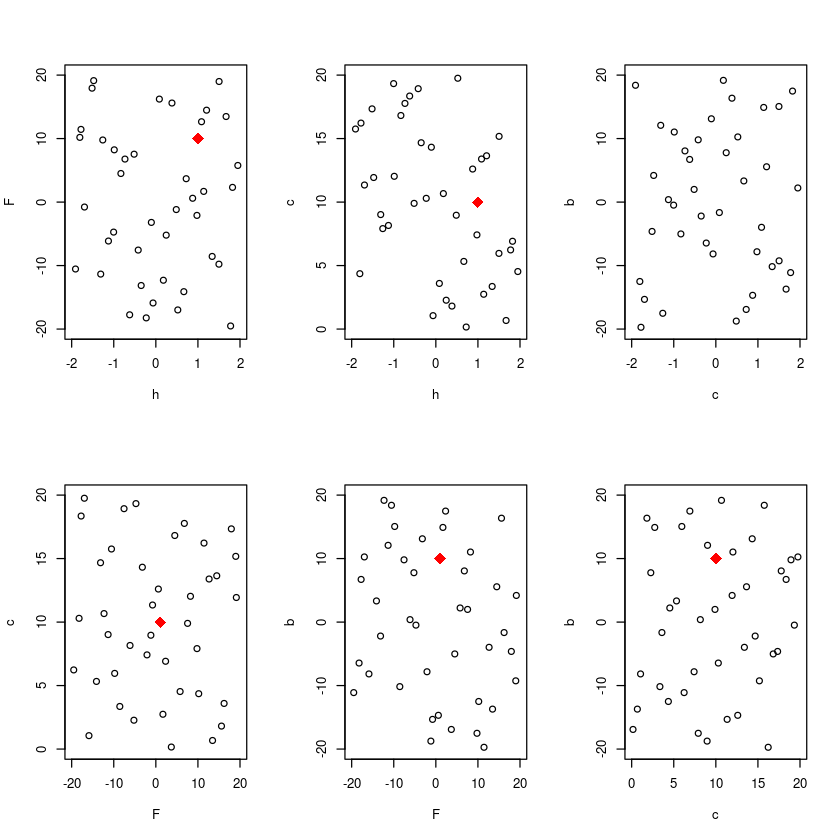

In [11]:
par(mfrow=c(2,3))
plot(inputs_wave1[,1], inputs_wave1[,2], xlab="h", ylab="F", xlim=c(-2,2), ylim=c(-20,20))
points(1, 10, col='red', pch=18, cex=2)
plot(inputs_wave1[,1], inputs_wave1[,3], xlab="h", ylab="c", xlim=c(-2,2), ylim=c(0,20))
points(1, 10, col='red', pch=18, cex=2)
plot(inputs_wave1[,1], inputs_wave1[,4], xlab="c", ylab="b", xlim=c(-2,2), ylim=c(-20,20))
points(10, 10, col='red', pch=18, cex=2)
plot(inputs_wave1[,2], inputs_wave1[,3], xlab="F", ylab="c", xlim=c(-20,20), ylim=c(0,20))
points(1, 10, col='red', pch=18, cex=2)
plot(inputs_wave1[,2], inputs_wave1[,4], xlab="F", ylab="b", xlim=c(-20,20), ylim=c(-20,20))
points(1, 10, col='red', pch=18, cex=2)
plot(inputs_wave1[,3], inputs_wave1[,4], xlab="c", ylab="b", xlim=c(0,20), ylim=c(-20,20))
points(10, 10, col='red', pch=18, cex=2)

In [12]:
extract_metrics_AMIP <- function(p, n_iter, dt, initX) {
    l96_mip = L96_amip$L96TwoLevel(X_init=initX, save_dt=dt, dt=dt, noYhist=FALSE, h=p[[1]], F=p[[2]], c=p[[3]], b=p[[4]])
    l96_mip$iterate(n_iter)
    mean_stats <- l96_mip$mean_stats(ax=as.integer(0), amip_metrics=FALSE)
    l96_mip$erase_history()
    return(mean_stats)
}

In [13]:
plan(multicore, workers = 8, gc = TRUE)

In [14]:
metrics_wave1 = future_sapply(1:nrow(inputs_wave1), function(r) extract_metrics_AMIP(inputs_wave1[r,], n_iter, 0.001, X_init), future.seed=NULL)
metrics_wave1 <- t(metrics_wave1)

## Principal Component Analysis for dimensionality reduction

In [15]:
# Generate data for testing PCA
n_samples_test <- 40
inputs_test <- np$array(lhs$generate(space$dimensions, as.integer(n_samples_test), random_state=as.integer(21)))
metrics_test = future_sapply(1:nrow(inputs_test), function(r) extract_metrics_AMIP(inputs_test[r,], n_iter, 0.001, X_init), future.seed=NULL)
metrics_test <- t(metrics_test)

In [16]:
# Scale metrics
my.scaler <- sklearn$preprocessing$StandardScaler()
X <- my.scaler$fit_transform(metrics_wave1)
X_test <- my.scaler$fit_transform(metrics_test)
input_size = dim(X)[[2]]

[1] 0.009501946

[1] 0.04239166

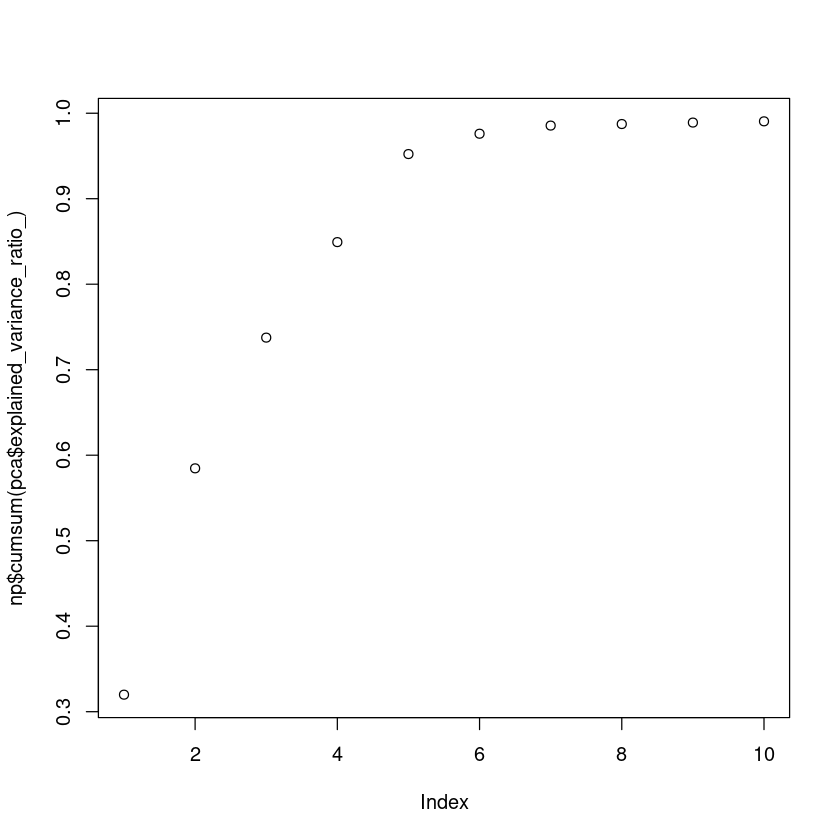

In [17]:
pca_dim <- 10
pca <- sklearn$decomposition$PCA(n_components=as.integer(pca_dim))
X_pca <- pca$fit_transform(X)
plot(np$cumsum(pca$explained_variance_ratio_))
X_pca_test <- pca$transform(X_test)
X_inverse_transform <- pca$inverse_transform(X_pca)
X_test_inverse_transform <- pca$inverse_transform(X_pca_test)
mse <- MSE(X_inverse_transform, X)
val_mse <- MSE(X_test_inverse_transform, X_test)
mse
val_mse

### Create the data matrix
We create a data frame with correct format to train an emulator as it is describe in https://bayesexeter.github.io/ExeterUQ_MOGP/Testing_ExeterUQ_mogp.html

We select 65 metrics for a given k (here $k=0$) in order to fit the emulators in a reasonable amount of time. Here we select the metrics 

$$
\boldsymbol{f}_0(Y)=\left(\begin{array}{c}
Y_{j,0} \\
Y_{j,0}Y_{j',0}
\end{array}\right), \forall j, j' \in J
$$

#### Scaling and Unscaling functions

In [18]:
rangeScale <- function(df, scaler, range = c(-1, 1)){
    for (i in 1:ncol(df)){
        min <- scaler[[i]][1]
        max <- scaler[[i]][2]
        df[,i] = (range[2] - range[1])*(df[,i] - min)/(max - min) + range[1]
    }
    return(df)
}
                                        
rangeUnscale <- function(df, scaler, range = c(-1, 1)){
    for (i in 1:ncol(df)){
        min <- scaler[[i]][1]
        max <- scaler[[i]][2]
        df[,i] = (max - min)*(df[,i] - range[1])/(range[2] - range[1]) + min
    }
    return(df)
}

In [19]:
# Arrange inputs (parameters) 
inputs_wave1 <- data.frame(inputs_wave1)
my_bounds <- data.frame(list(c(-2, 2), c(-20,20), c(0, 20), c(-20, 20)))
inputs_wave1_scaled <- rangeScale(inputs_wave1, my_bounds, range = c(-1, 1))
names(inputs_wave1_scaled) <- c('h', 'F', 'c', 'b')


X_pca_wave1 <- data.frame(X_pca)
N = nrow(inputs_wave1) 
noise <- rnorm(N, 0.5, 0)
tData <- data.frame(cbind(inputs_wave1_scaled, noise, X_pca_wave1))
names(tData)[names(tData) == "noise"] <- "Noise"
         
head(tData)

,h,F,c,b,Noise,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0.24272128,-0.0589672,-0.1036056,-0.93729158,0.5,-7.999036,-1.998931,0.5472175,-2.303677,3.0495415,-0.06532971,-0.04554001,-0.10330051,-0.019686916,-0.09308730
2,0.74974022,-0.4890278,-0.4040966,0.75287034,0.5,-3.889717,1.012512,-3.7657556,1.638929,5.0131601,0.27748551,0.55989537,0.97761164,0.433295860,0.38931748
3,-0.63048968,0.4890101,-0.2089569,-0.87576325,0.5,5.179530,-7.273790,2.1366790,-2.661526,-0.3593291,-0.15987963,0.05849452,0.02740490,-0.161975020,-0.31210587
4,-0.88941915,0.5723452,0.6221371,-0.98601571,0.5,4.497722,-6.870800,3.3729779,-1.815457,1.8487866,-0.11638668,-0.13216046,0.09172756,-0.069690263,-0.02368242
5,-0.56311389,-0.3067018,-0.1841641,0.01920742,0.5,-6.901841,0.864476,5.2737308,6.563197,-3.1577902,-2.61691070,1.19794859,-0.08105152,0.328652261,-0.00421110
6,-0.05324286,-0.1601800,0.4320671,0.65591650,0.5,-8.276543,-1.178383,0.8240324,-1.369297,1.1994862,0.54269028,-0.11795986,-0.23017567,0.009421731,0.06082659


### Training emulator

In [20]:
cands <- names(tData)[1:4]
em_wave1 <- BuildNewEmulators(tData, HowManyEmulators = ncol(X_pca), meanFun = "fitted", additionalVariables = cands) # 

[1] "Max reduction is 1.9141076603892 using F"
[1] "Max reduction is 3.10812421695245 using F"
[1] "Max reduction is 0.238371840631519 using h"
[1] "Max reduction is 0.44438601187453 using h"
[1] "Max reduction is 0.0704109397273183 using h"
[1] "Max reduction is 0.0868301542016907 using b"
[1] "Max reduction is 0.156277807516713 using c"
[1] "Max reduction is 0.19069805220757 using Three Way Interactions with F"
[1] "No further terms permitted with the given degrees of freedom"

Call:
lm(formula = X1 ~ F + I(F^2) + h + I(h^2) + I(h^3) + b + c + 
    I(h * F) + I(b * F) + I(c * F) + I(b * h) + I(c * h) + I(c * 
    b) + I(F * h * F) + I(F * b * F) + I(F * c * F) + I(F * b * 
    h) + I(F * c * h) + I(F * c * b), data = tData)

Residuals:
    Min      1Q  Median      3Q     Max 
-3.7635 -0.7534 -0.0518  0.6266  2.9711 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)  -6.80642    0.61987 -10.980 6.42e-10 ***
F             8.65643    0.64914  13.335 2.06e-

We can use Leave One Out to verify if our GPs fit our metrics correctly.

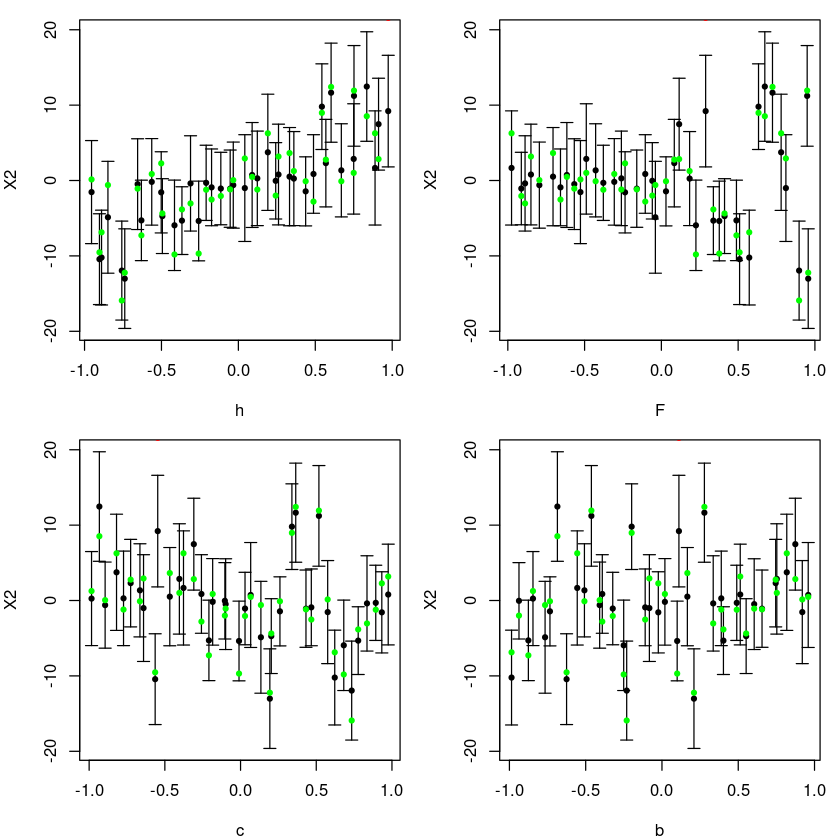

In [21]:
tLOOs <- LOO.plot(Emulators = em_wave1, which.emulator = 2, ParamNames = cands)

### Compute implausibility

We will compute implausibility as it is described in *Williamson & al. (2017)*.

$$
I_i(x_0) = \frac{|z_i - \mathbf{E}[f_i(x_0)]|}{|Var[z_i - \mathbf{E}[f_i(x_0)]]|} \\
I(x_0) = max_i(I_i(x_0))
$$

We consider that $Var[z_i - \mathbf{E}[f_i(x_0)]] = Var[e] +
Var[g] + Var[f(x_0)]$  like it is describe in *Williamson & al. (2017)*. 

With $Var[e]$ the observational
error variance, $Var[g]$ the model discrepancy variance
and $Var[f(x)]$ the variance of the emulator.

In [22]:
tDisc <- rep(0, ncol(X_pca_wave1)) # model discrepancy variance Var[g] 
tObsErr <- rep(0, ncol(X_pca_wave1)) # observational error variance Var[e]
obs_scaled <- my.scaler$transform(t(observations))
tObs <-  as.vector(pca$transform(obs_scaled)) # Observations

We generate a large sampling of the parameter space (that we have scaled) and will compute implausibility for each point of this parameters space.

In [23]:
sample_size <- 100000
nparam <- length(names(em_wave1$fitting.elements$Design))
Xp <- as.data.frame(2*randomLHS(sample_size, nparam)-1)
names(Xp) <- names(em_wave1$fitting.elements$Design)
system.time(Timps <- ImplausibilityMOGP(NewData=Xp, Emulator=em_wave1, Discrepancy=tDisc, Obs=tObs, ObsErr=tObsErr))

   user  system elapsed 
  7.688   3.243   2.511 

In [24]:
VarNames <- names(Xp)
valmax = 0 #how many outputs can be above the implausibility cut off
cutoff <- 3 #the implausibility cut off
param.def = data.frame(h=c(1),F=c(10),c=c(10),b=c(10)) #the default parameters of the model (on [-1,1])
param.defaults.norm = rangeScale(param.def, my_bounds, range(-1,1))
print(param.defaults.norm)

    h   F c   b
1 0.5 0.5 0 0.5


In [25]:
NROY1 <- which(rowSums(Timps <= cutoff) >= em_wave1$mogp$n_emulators -valmax)
scoreNROY1 <- length(NROY1)/dim(Xp)[1]
scoreNROY1

[1] 0.07456

### Layout of NROY space

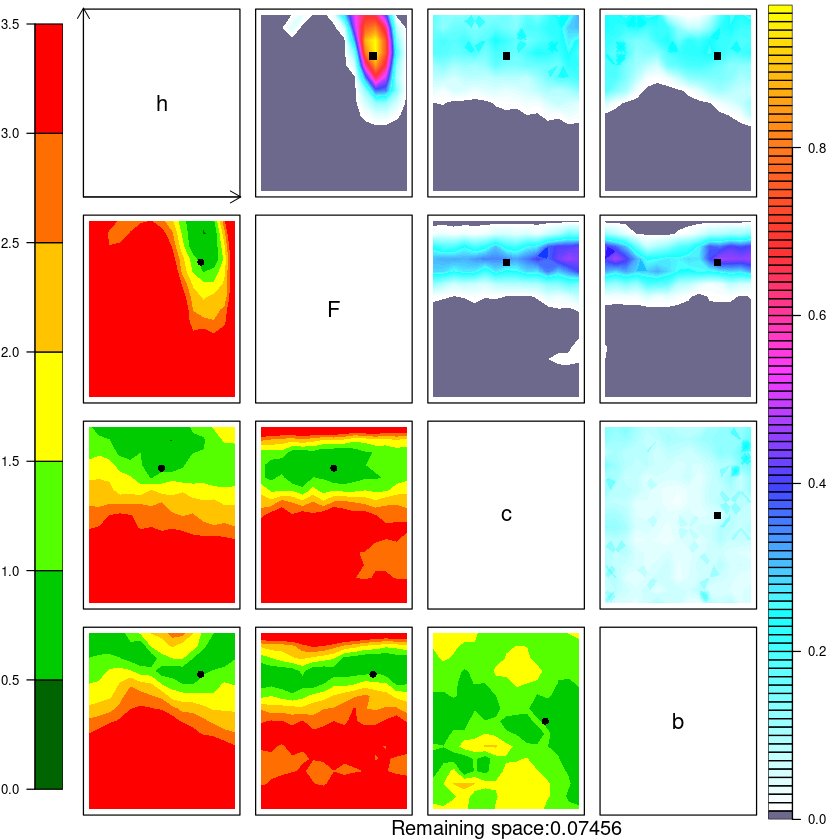

In [26]:
ImpData_wave1 = cbind(Xp, Timps)
ImpListM1 = CreateImpList(whichVars = 1:nparam, VarNames=VarNames, ImpData=ImpData_wave1, nEms=em_wave1$mogp$n_emulators, whichMax=valmax+1)
imp.layoutm11(ImpListM1,VarNames,VariableDensity=FALSE,newPDF=FALSE,the.title=paste("InputSpace_wave",WAVEN,".pdf",sep=""),newPNG=FALSE,newJPEG=FALSE,newEPS=FALSE,Points=matrix(param.defaults.norm,ncol=nparam))
mtext(paste("Remaining space:",scoreNROY1,sep=""), side=1)

## Second Wave

We will generate a large number of samples in the entire parameters space in order to obtain *n_samples* samples in the NROY space created with the emulator *em_wave1*.

In [27]:
n <- ceiling(n_samples*4/scoreNROY1)

In [28]:
space <- skSpace$Space(list(c(-1, 1), c(-1,1), c(-1, 1), c(-1, 1))) ## we use a scaled space
inputs_wave2_scaled_temp <- np$array(lhs$generate(space$dimensions, as.integer(n), random_state=as.integer(42)))

We find the points of NewData wich fall in the NROY space of each emulator in *emulators*.

In [29]:
parameters_space <- function(emulators, NewData, n_samples=n_samples){
    NROY_em <- 1:nrow(NewData)
    for (em in emulators){
        imp_em <- ImplausibilityMOGP(NewData=NewData, Emulator=em, Discrepancy=tDisc, Obs=tObs, ObsErr=tObsErr)
        NROY_temp <- which(rowSums(imp_em <= cutoff) >= em$mogp$n_emulators - valmax)
        NROY_em <- intersect(NROY_em, NROY_temp)
    }
    return(sample(NROY_em, n_samples))
}

In [30]:
emulators <- list(em_wave1)
NROY_temp_wave2 <- parameters_space(emulators, inputs_wave2_scaled_temp, 30)

We now have our new inputs for wave 2.

We need to unscale those inputs for metrics simulations.

In [31]:
inputs_wave2_scaled <- inputs_wave2_scaled_temp[NROY_temp_wave2,]
inputs_wave2 <- rangeUnscale(inputs_wave2_scaled, my_bounds, range = c(-1, 1))

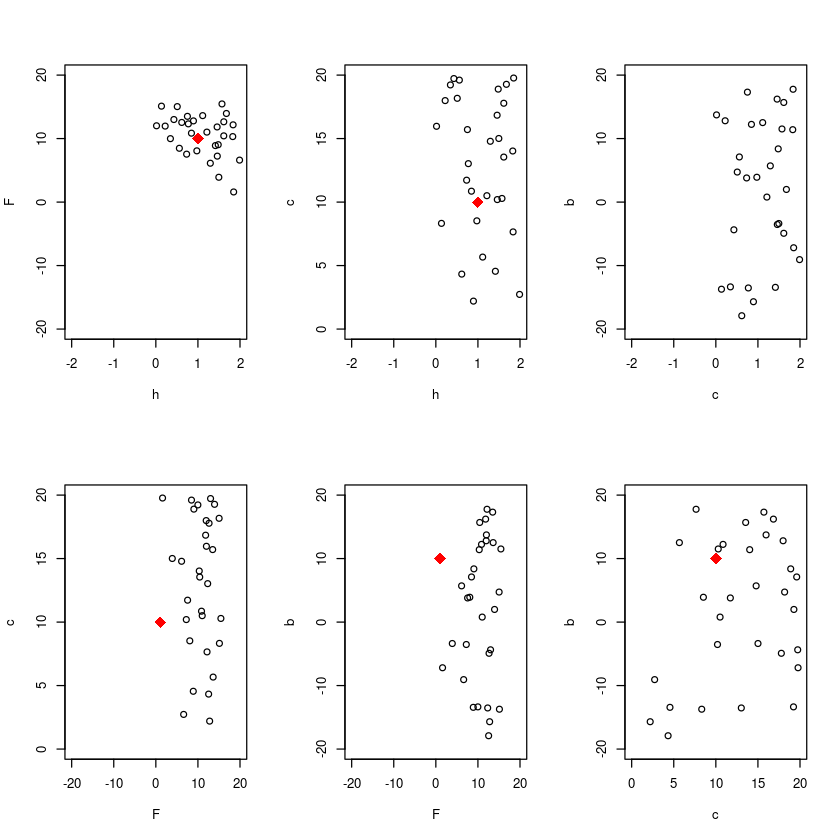

In [32]:
par(mfrow=c(2,3))
plot(inputs_wave2[,1], inputs_wave2[,2], xlab="h", ylab="F", xlim=c(-2,2), ylim=c(-20,20))
points(1, 10, col='red', pch=18, cex=2)
plot(inputs_wave2[,1], inputs_wave2[,3], xlab="h", ylab="c", xlim=c(-2,2), ylim=c(0,20))
points(1, 10, col='red', pch=18, cex=2)
plot(inputs_wave2[,1], inputs_wave2[,4], xlab="c", ylab="b", xlim=c(-2,2), ylim=c(-20,20))
points(10, 10, col='red', pch=18, cex=2)
plot(inputs_wave2[,2], inputs_wave2[,3], xlab="F", ylab="c", xlim=c(-20,20), ylim=c(0,20))
points(1, 10, col='red', pch=18, cex=2)
plot(inputs_wave2[,2], inputs_wave2[,4], xlab="F", ylab="b", xlim=c(-20,20), ylim=c(-20,20))
points(1, 10, col='red', pch=18, cex=2)
plot(inputs_wave2[,3], inputs_wave2[,4], xlab="c", ylab="b", xlim=c(0,20), ylim=c(-20,20))
points(10, 10, col='red', pch=18, cex=2)

In [33]:
metrics_wave2 = future_sapply(1:nrow(inputs_wave2), function(r) extract_metrics_AMIP(inputs_wave2[r,], n_iter, 0.001, X_init), future.seed=NULL)
metrics_wave2 <- t(metrics_wave2)

## Principal Component Analysis for dimensionality reduction

In [ ]:
inputs_test_wave2_scaled_temp <- np$array(lhs$generate(space$dimensions, as.integer(n), random_state=as.integer(21)))

In [ ]:
NROY_temp_test_wave2 <- parameters_space(emulators, inputs_test_wave2_scaled_temp, 40, tDisc, tObs, tObserr)

In [ ]:
inputs_test_wave2_scaled <- inputs_test_wave2_scaled_temp[NROY_temp_test_wave2,]
inputs_test_wave2 <- rangeUnscale(inputs_test_wave2_scaled, my_bounds, range = c(-1, 1))

In [ ]:
metrics_test_wave2 = future_sapply(1:nrow(inputs_test_wave2), function(r) extract_metrics_AMIP(inputs_test_wave2[r,], n_iter, 0.001, X_init), future.seed=NULL)
metrics_test_wave2 <- t(metrics_test_wave2)

In [38]:
# Scale metrics
my.scaler_wave2 <- sklearn$preprocessing$StandardScaler()
X_wave2 <- my.scaler_wave2$fit_transform(metrics_wave2)
X_test_wave2 <- my.scaler_wave2$fit_transform(metrics_test_wave2)

[1] 0.3367016

[1] 0.5690442

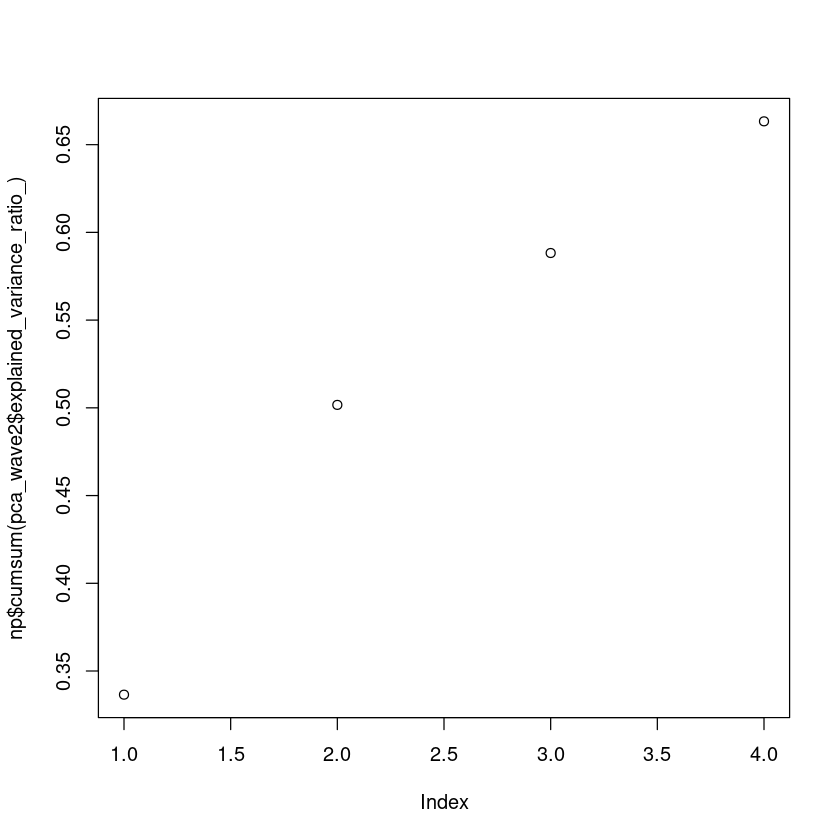

In [39]:
pca_dim <- 4
pca_wave2 <- sklearn$decomposition$PCA(n_components=as.integer(pca_dim))
X_pca_wave2 <- pca_wave2$fit_transform(X_wave2)
plot(np$cumsum(pca_wave2$explained_variance_ratio_))
X_pca_test_wave2 <- pca_wave2$transform(X_test_wave2)
X_inverse_transform_wave2 <- pca_wave2$inverse_transform(X_pca_wave2)
X_test_inverse_transform_wave2 <- pca_wave2$inverse_transform(X_pca_test_wave2)
mse <- MSE(X_inverse_transform_wave2, X_wave2)
val_mse <- MSE(X_test_inverse_transform_wave2, X_test_wave2)
mse
val_mse

### Create the data matrix

In [40]:
# Arrange inputs (parameters) 
inputs_wave2 <- data.frame(inputs_wave2)
my_bounds <- data.frame(list(c(-2, 2), c(-20,20), c(0, 20), c(-20, 20)))
inputs_wave2_scaled <- rangeScale(inputs_wave2, my_bounds, range = c(-1, 1))
names(inputs_wave2_scaled) <- c('h', 'F', 'c', 'b')


X_pca_wave2 <- data.frame(X_pca_wave2)
N = nrow(inputs_wave2) 
noise <- rnorm(N, 0.5, 0)
tData_wave2 <- data.frame(cbind(inputs_wave2_scaled, noise, X_pca_wave2))
names(tData_wave2)[names(tData_wave2) == "noise"] <- "Noise"
         
head(tData_wave2)

,h,F,c,b,Noise,X1,X2,X3,X4
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0.5884079,0.5174803,-0.3281075,-0.9726522,0.5,-9.564756,2.357710,-0.4363459,-0.8415012
2,0.8125898,0.5687620,-0.7165286,0.8710726,0.5,6.180043,1.215960,9.0219393,-2.7287559
3,0.8735972,0.4943709,-0.9205954,-0.3773151,0.5,5.800731,6.781856,6.0436028,8.5367935
4,0.2993862,0.6706787,0.8280033,0.6244166,0.5,-7.519815,4.776558,-4.5224290,-6.4995303
5,0.3983290,0.5268305,0.9273165,0.7207411,0.5,-5.951526,3.194859,-3.3132237,-1.3606987
6,0.7620318,0.6099260,-0.6615958,0.6797927,0.5,9.198540,1.153756,7.3566540,-8.2056007


### Training emulator

In [41]:
em_wave2 <- BuildNewEmulators(tData_wave2, HowManyEmulators = ncol(X_pca_wave2), meanFun = "fitted", additionalVariables = cands) # 

[1] "Max reduction is 0.186046280329933 using b"
[1] "Max reduction is 1.5585652994644 using b"
[1] "Max reduction is 0.859686062424935 using h"
[1] "Max reduction is 0.0360520637922797 using F"
[1] "Max reduction is 0.801304933118317 using c"
[1] "Max reduction is 1.45443545509968 using c"
[1] "Max reduction is 0.0934913939360378 using h"
[1] "Max reduction is 0.118350231215623 using h"
[1] "No further terms permitted with the given degrees of freedom"

Call:
lm(formula = X1 ~ b + I(b^2) + h + I(h^2) + I(h^3) + F + c + 
    I(c^2) + I(h * b) + I(F * b) + I(c * b) + I(F * h) + I(c * 
    h) + I(c * F), data = tData)

Residuals:
    Min      1Q  Median      3Q     Max 
-5.3369 -1.1750 -0.1283  1.1640  4.5568 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)   99.194     29.450   3.368 0.004224 ** 
b            -19.859     14.135  -1.405 0.180404    
I(b^2)       -17.818      2.708  -6.580 8.74e-06 ***
h            -51.557     98.085  -0.526 0.606822    
I(

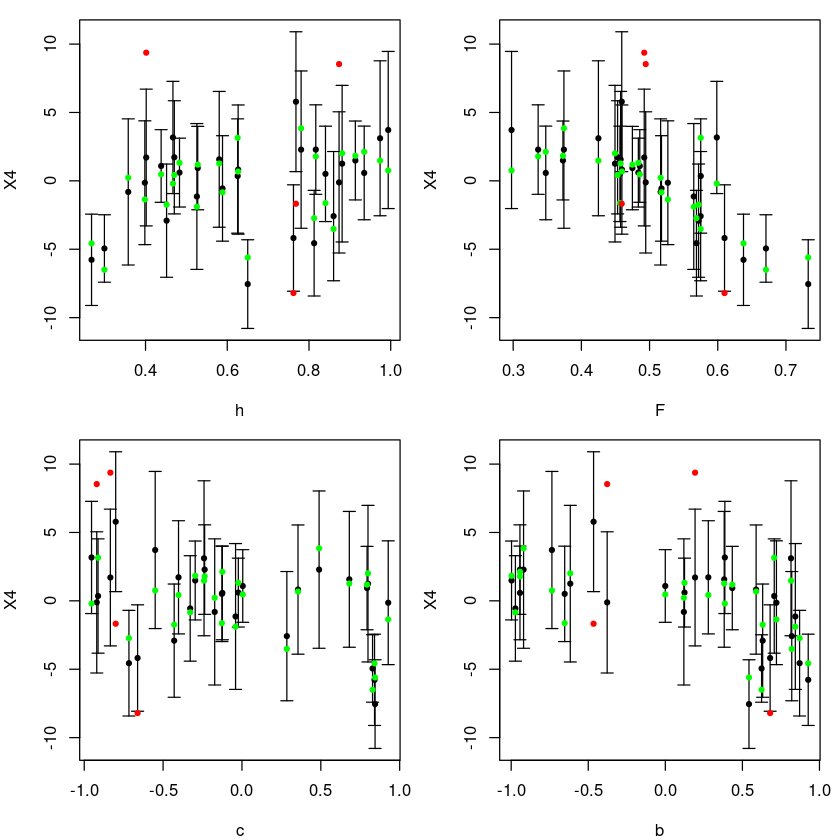

In [42]:
tLOOs <- LOO.plot(Emulators = em_wave2, which.emulator = 4, ParamNames = cands)

### Compute implausibility

In [43]:
tDisc_wave2 <- rep(0, ncol(X_pca_wave2)) # model discrepancy variance Var[g] 
tObsErr_wave2 <- rep(0, ncol(X_pca_wave2)) # observational error variance Var[e]
obs_scaled_wave2 <- my.scaler_wave2$transform(t(observations))
tObs_wave2 <-  as.vector(pca_wave2$transform(obs_scaled_wave2)) # Observations

In [44]:
sample_size <- 100000
nparam <- length(names(em_wave2$fitting.elements$Design))
Xp_wave2 <- as.data.frame(2*randomLHS(sample_size, nparam)-1)
names(Xp_wave2) <- names(em_wave2$fitting.elements$Design)
system.time(Timps_wave2 <- ImplausibilityMOGP(NewData=Xp_wave2, Emulator=em_wave2, Discrepancy=tDisc_wave2, Obs=tObs_wave2, ObsErr=tObsErr_wave2))

   user  system elapsed 
  1.913   1.161   1.019 

In [45]:
Timps_wave2

6.315557,42.15554,18.20033,21.52899
6.006090,34.74209,12.73614,17.97177
7.758612,49.58113,10.17045,21.80387
6.183975,44.16622,14.94759,30.80427
6.464404,43.79981,13.67676,19.75257
6.317852,45.79408,15.94079,34.25156
5.183963,49.59221,13.82423,29.30819
6.406527,47.96769,14.15867,29.26519
8.281680,26.44828,15.66573,17.02655
6.434463,38.70092,16.36689,23.85836
6.297838,40.00234,12.98791,19.37715


In [46]:
valmax = 0 #Set to 2 in order to have a "more steady" NROY space
cutoff <- 3 #the implausibility cut off

In [47]:
NROY2 <- which(rowSums(Timps_wave2 <= cutoff) >= em_wave2$mogp$n_emulators -valmax)
scoreNROY2 <- length(NROY2)/dim(Xp_wave2)[1]

### Layout of NROY space

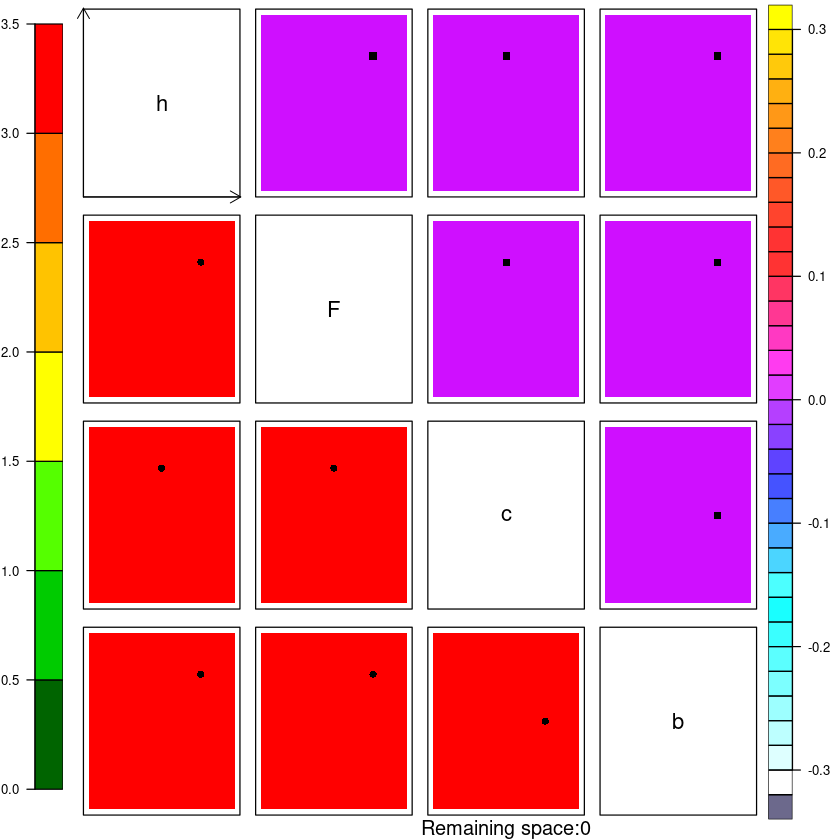

In [48]:
ImpData_wave2 = cbind(Xp_wave2, Timps_wave2)
ImpListM2 = CreateImpList(whichVars = 1:nparam, VarNames=VarNames, ImpData=ImpData_wave2, nEms=em_wave2$mogp$n_emulators, whichMax=valmax+1)
imp.layoutm11(ImpListM2,VarNames,VariableDensity=FALSE,newPDF=FALSE,the.title=paste("InputSpace_wave",WAVEN,".pdf",sep=""),newPNG=FALSE,newJPEG=FALSE,newEPS=FALSE,Points=matrix(param.defaults.norm,ncol=nparam))
mtext(paste("Remaining space:",scoreNROY2,sep=""), side=1)

## Third Wave

In [58]:
n <- ceiling(n_samples*3/scoreNROY2)

In [59]:
inputs_wave3_scaled_temp <- np$array(lhs$generate(space$dimensions, as.integer(n), random_state=as.integer(42)))

Warning message in py_resolve_dots(list(...)):
“NAs introduced by coercion to integer range”


ERROR: Error in py_call_impl(callable, dots$args, dots$keywords): ValueError: Number of samples, -2147483647, must be non-negative.

Detailed traceback: 
  File "/home/homer/.local/lib/python3.8/site-packages/skopt/sampler/lhs.py", line 88, in generate
    h_opt = self._lhs_normalized(n_dim, n_samples, rng)
  File "/home/homer/.local/lib/python3.8/site-packages/skopt/sampler/lhs.py", line 134, in _lhs_normalized
    x = np.linspace(0, 1, n_samples + 1)
  File "<__array_function__ internals>", line 5, in linspace
  File "/home/homer/.local/lib/python3.8/site-packages/numpy/core/function_base.py", line 115, in linspace
    raise ValueError("Number of samples, %s, must be non-negative." % num)



In [ ]:
emulators <- list(em_wave1, em_wave2)
NROY_temp_wave3 <- parameters_space(emulators, inputs_wave3_scaled_temp, n_samples=30)

In [ ]:
length(NROY_temp_wave3)

In [ ]:
input_wave3_scaled <- inputs_wave3_scaled_temp[sample(NROY_temp_wave3, n_samples),]
input_wave3 <- rangeUnscale(input_wave3_scaled, my_bounds, range = c(-1, 1))

In [ ]:
par(mfrow=c(2,2))
plot(input_wave3[,1], input_wave3[,2], xlab="h", ylab="c", xlim=c(-2,2), ylim=c(0,20))
points(1, 10, col='red', pch=18, cex=2)
plot(input_wave3[,1], input_wave3[,3], xlab="h", ylab="b", xlim=c(-2,2), ylim=c(-20,20))
points(1, 10, col='red', pch=18, cex=2)
plot(input_wave3[,2], input_wave3[,3], xlab="c", ylab="b", xlim=c(0,20), ylim=c(-20,20))
points(10, 10, col='red', pch=18, cex=2)

In [ ]:
metrics_wave3 = future_sapply(1:nrow(input_wave3), function(r) extract_metrics_AMIP(input_wave3[r,], n_iter, 0.001, X_hist), future.seed=NULL) 
metrics_wave3 <- t(metrics_wave3)

### Create the data matrix

In [ ]:
input_wave3_scaled <- data.frame(input_wave3_scaled)
names(input_wave3_scaled) <- c('h', 'c', 'b')


metrics_k_wave3 <- data.frame(metrics_wave3)
N = nrow(metrics_k_wave3) 
noise <- rnorm(N, 0, 0) # Tester à 0.5
tData_wave3 <- data.frame(cbind(input_wave3_scaled, noise, metrics_k_wave3))
names(tData_wave3)[names(tData_wave3) == "noise"] <- "Noise"
         
head(tData_wave3)

### Training emulator

In [ ]:
em_wave3 <- BuildNewEmulators(tData_wave3, HowManyEmulators = ncol(metrics_wave3), meanFun = "fitted", additionalVariables = cands) # 

In [ ]:
tLOOs <- LOO.plot(Emulators = em_wave3, which.emulator = 12, ParamNames = cands)

### Compute implausibility

In [ ]:
sample_size <- 100000
nparam <- length(names(em_wave3$fitting.elements$Design))
Xp_wave3 <- as.data.frame(2*randomLHS(sample_size, nparam)-1)
names(Xp_wave3) <- names(em_wave3$fitting.elements$Design)
system.time(Timps_wave3 <- ImplausibilityMOGP(NewData=Xp_wave3, Emulator=em_wave3, Discrepancy=tDisc, Obs=tObs, ObsErr=tObsErr))

In [ ]:
valmax = 0 #how many outputs can be above the implausibility cut off
cutoff <- 3 #the implausibility cut off

In [ ]:
NROY3 <- which(rowSums(Timps_wave3 <= cutoff) >= em_wave3$mogp$n_emulators -valmax)
scoreNROY3 <- length(NROY3)/dim(Xp_wave3)[1]

### Layout of NROY space

In [ ]:
ImpData_wave3 = cbind(Xp_wave3, Timps_wave3)
ImpListM3 = CreateImpList(whichVars = 1:nparam, VarNames=VarNames, ImpData=ImpData_wave3, nEms=em_wave3$mogp$n_emulators, whichMax=valmax+1)
imp.layoutm11(ImpListM3,VarNames,VariableDensity=FALSE,newPDF=FALSE,the.title=paste("InputSpace_wave",WAVEN,".pdf",sep=""),newPNG=FALSE,newJPEG=FALSE,newEPS=FALSE,Points=matrix(param.defaults.norm,ncol=nparam))
mtext(paste("Remaining space:",scoreNROY3,sep=""), side=1)

## Fourth Wave

In [ ]:
n <- ceiling(n_samples*/scoreNROY3)

In [ ]:
inputs_wave4_scaled_temp <- np$array(lhs$generate(space$dimensions, as.integer(n), random_state=as.integer(42)))

In [ ]:
emulators <- list(em_wave1, em_wave2, em_wave3)
NROY_temp_wave4 <- parameters_space(emulators, inputs_wave4_scaled_temp, 30)

In [ ]:
input_wave4_scaled <- inputs_wave4_scaled_temp[sample(NROY_temp_wave4, n_samples),]
input_wave4 <- rangeUnscale(input_wave4_scaled, my_bounds, range = c(-1, 1))

In [ ]:
par(mfrow=c(2,2))
plot(input_wave4[,1], input_wave4[,2], xlab="h", ylab="c", xlim=c(-2,2), ylim=c(0,20))
points(1, 10, col='red', pch=18, cex=2)
plot(input_wave4[,1], input_wave4[,3], xlab="h", ylab="b", xlim=c(-2,2), ylim=c(-20,20))
points(1, 10, col='red', pch=18, cex=2)
plot(input_wave4[,2], input_wave4[,3], xlab="c", ylab="b", xlim=c(0,20), ylim=c(-20,20))
points(10, 10, col='red', pch=18, cex=2)

In [ ]:
metrics_wave4 = future_sapply(1:nrow(input_wave4), function(r) extract_metrics_AMIP(input_wave4[r,], n_iter, 0.001, X_hist), future.seed=NULL) 

### Create the data matrix

In [ ]:
input_wave4_scaled <- data.frame(input_wave4_scaled)
names(input_wave4_scaled) <- c('h', 'c', 'b')


metrics_k_wave4 <- data.frame(t(metrics_wave4)[, metrics_index_k])
N = nrow(metrics_k_wave4) 
noise <- rnorm(N, 0, 0)
tData_wave4 <- data.frame(cbind(input_wave4_scaled, noise, metrics_k_wave4))
names(tData_wave4)[names(tData_wave4) == "noise"] <- "Noise"
         
head(tData_wave4)

### Training emulator

In [ ]:
em_wave4 <- BuildNewEmulators(tData_wave4, HowManyEmulators = ncol(metrics_wave4), meanFun = "fitted", additionalVariables = cands) # 

We can use Leave One Out to verify if our GPs fit our metrics correctly.

In [ ]:
tLOOs <- LOO.plot(Emulators = em_wave4, which.emulator = 12, ParamNames = cands)

### Compute implausibility

In [ ]:
sample_size <- 100000
nparam <- length(names(em_wave4$fitting.elements$Design))
Xp_wave4 <- as.data.frame(2*randomLHS(sample_size, nparam)-1)
names(Xp_wave4) <- names(em_wave4$fitting.elements$Design)
system.time(Timps_wave4 <- ImplausibilityMOGP(NewData=Xp_wave4, Emulator=em_wave4, Discrepancy=tDisc, Obs=tObs, ObsErr=tObsErr))

In [ ]:
valmax = 0 #how many outputs can be above the implausibility cut off
cutoff <- 3 #the implausibility cut off

In [ ]:
NROY4 <- which(rowSums(Timps_wave4 <= cutoff) >= em_wave4$mogp$n_emulators -valmax)
scoreNROY4 <- length(NROY4)/dim(Xp_wave4)[1]

### Layout of NROY space

In [ ]:
ImpData_wave4 = cbind(Xp_wave4, Timps_wave4)
ImpListM4 = CreateImpList(whichVars = 1:nparam, VarNames=VarNames, ImpData=ImpData_wave4, nEms=em_wave4$mogp$n_emulators, whichMax=valmax+1)
imp.layoutm11(ImpListM4,VarNames,VariableDensity=FALSE,newPDF=FALSE,the.title=paste("InputSpace_wave",WAVEN,".pdf",sep=""),newPNG=FALSE,newJPEG=FALSE,newEPS=FALSE,Points=matrix(param.defaults.norm,ncol=nparam))
mtext(paste("Remaining space:",scoreNROY4,sep=""), side=1)